# 人脸检测的传统方法2

传统方法对比深度学习的一个主要弱势在于特征不够泛化，不能描述抽象的概念。

对于这样的特征，就需要更好的分类器，或者更加复杂的分类器。

在前深度学习时代，提高分类器性能的一个主要手段在于**集成**。(深度学习时代也是，kaggle中有大量的高分项目都采用了集成策略。)

## 集成学习

集成算法，是指将一组不同的分类器整合起来，相互配合地对目标进行预测。

其中所涉及的一个主要内容就是

### 结合策略

1. 平均法

把若干个学习器的输出进行加权平均，得到最终结果的输出。

其中，权重设置为可学习，就能得到更加鲁棒的学习器。

2. 投票法

少数服从多数的策略。

包括：多数投票法，或者加权投票法等。

同理，也可以设置可学习的分类器权重。

3. stacking

将一部分的分类器的输出，作为另一部分学习器的输入，构建次级模型来提高模型性能。

例如，将一组20个svm的分类器的十分类预测结果组合到一起，输入一个可以接受200维输入的分类器中，进一步预测10分类结果。    


## Boosting算法

强学习：分类精度比较高的分类器

弱学习：分类精度比随机分类高一点的分类器

通过集成了多个弱学习分类器，通过非随机的组合，得到一个强分类器。

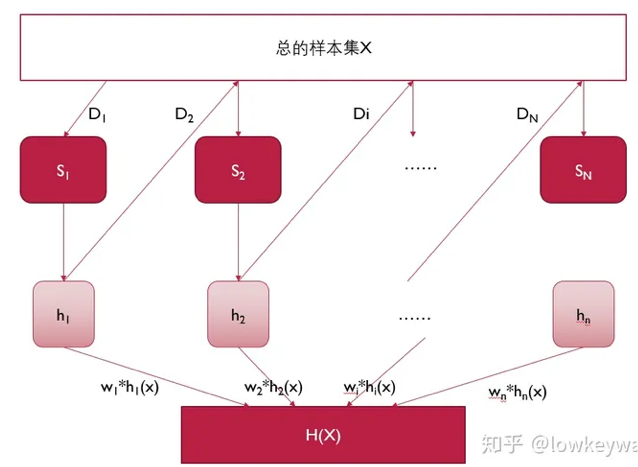

### adaboost模型

adaboost模型是一种boosting算法

假设训练样本为$$X=\{(x_1, y_1), (x_2, y_2), ..., (x_m, ym)\}$$

那么第$k$个弱分类器的样本权重系数为：

$$D(k)=(w_{k1}, w_{k2}, ..., w_{kn})$$

其中，$\sum_{i=1}^n w_{ki} = 1$

那么，对于第$k$个分类器$G_k$的误差可计算为

$$e_k=P(G_k(x_i)\neq y_i) = \sum_{i=1}^m w_{ki}I(G_k(x_i)\neq y_i)$$

其中$I$是一个指示函数，定义为

$$I=\begin{cases}
1, & \text{if } G_k(x_i) \neq y_i \\
0, & \text{otherwise}
\end{cases}$$

* * *

更新权重

已知第$k$个弱分类器的样本权重系数为

$$D(k)=(w_{k1}, w_{k2}, ..., w_{kn})$$

那么第k+1个分类器的样本权重系数为

$$w_{k+1, i} = \frac{w_{k,i}}{Z_k}\exp(-\alpha_ky_iG_k(x_i))$$

其中，$\alpha$为分类器的系数，$Z_k$为归一化因子

**思考：为何这样设置？**

进而，计算弱学习器的系数

$$\alpha_k=\frac{1}{2}\log\frac{1-e_k}{e_k}$$

**思考**：会如何影响模型？

最终，采用加权平均法，得到最终的分类器如下

$$f(x)=\text{sign}(\sum_{k=1}^K\alpha_kG_k(x))$$

总结：adaboost采用了较低的成本，得到了一个性能与SVM差不多的分类器。

其特点在于，对于难分样本，具有很好的效果。且不容易过拟合。

但是对于噪声和扰动较为敏感。

## Haar特征

Haar是一种用模板来描述图像变化的工具，所得到的结果可以作为图像特征。

根据目标不同，设计了多种不同的模板。

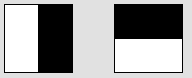
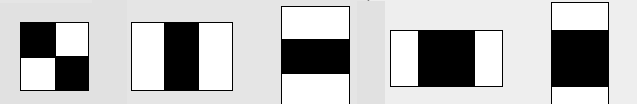
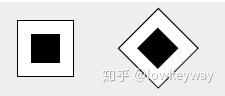

这些特征，实际上就是卷积神经网络的灵感源泉之一。

在实际运算中，haar特征的精度并不高。但结合积分图，可以快速计算图像特征。

具体计算方法是，白色区域的和 减去 黑色区域的和.

本质上，白色区域的值为1，黑色区域的值为0。

如何利用haar特征进行较好的目标检测？

## adaboost的级联算法

首先，用提取的haar特征，训练一个adaboost分类器。

分类器会给出一个决策值，如果这个值大于设定的阈值，则认为是人脸，如果小于，则认为不是人脸。

然而，阈值的设定非常难，且不鲁棒。

那么之所以可能会分错，可能是因为特征不够泛化。

所以，我们重新设置haar的参数，来获得不同的特征表达。

并且用这种特征，训练一个新的分类器。

两种分类器之间，采用级联方式链接

如果A分类器能够确定他是一个目标，则认为是一个目标

如果不能确定是一个目标，则会把他交给B分类器继续判断。

依次类推，直到最后的分类器也不能确定他是一个目标，则不是目标。

同理，上述过程可以反过来，如果有一级分类器判断他不是，则他就不是目标；直到最后一级分类器也认定是一个人脸，则才是一个人脸。

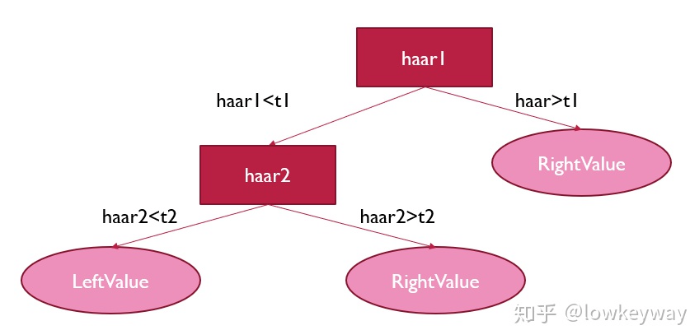

以上过程就是经典的机器学习理论之一：决策树

## 决策树集成

一个决策树可能并不鲁棒。

我们将数据集划分成若干个重叠的部分，分别训练若干个决策树，并用加权集成的方式，来得到最终的结果。

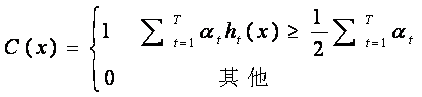

### 训练与推理

级联分类器的训练过程，可采用opencv提供的工具来实现。

具体可见该链接

[级联分类器的训练-英](https://docs.opencv.org/4.2.0/dc/d88/tutorial_traincascade.html)

[级联分类器的训练-中](https://zhuanlan.zhihu.com/p/407571417)

具体上，要使用到`opencv_traincascade.exe`训练准备好的数据。

不过，也可以使用opencv提供的事先训练好的模型直接进行推理。具体链接为[训练好的各种级联模型](https://github.com/opencv/opencv/tree/master/data/haarcascades)

以训练好的模型为例，一个haar级联分类器的人脸检测代码实现如下

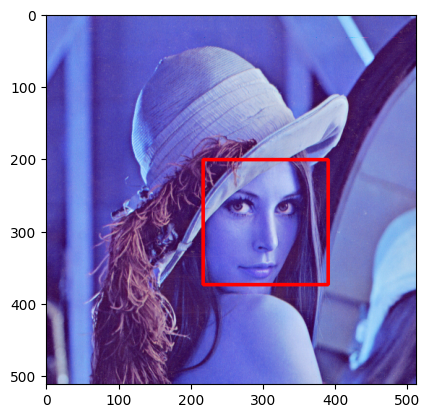

In [17]:
import cv2
import matplotlib.pyplot as plt

face_detector = cv2.CascadeClassifier('../../dataset/haarcascade_frontalface_default.xml')
img = cv2.imread('../../dataset/lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_detector.detectMultiScale(gray,1.1, 4 )
for (x,y, w, h) in faces:
    cv2.rectangle(img, pt1 = (x,y),pt2 = (x+w, y+h), color = (255,0,0),thickness =  3)
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = img[y:y+h, x:x+w]

plt.imshow(img)

## 其他的方法与思路

前深度学习时代，思路和方法百花齐放，人们采用不同的方式来实现目标检测。

主要来说，研究的重点涉及两个方面：特征和分类器。

### 特征层面

特征，本质上的研究问题在于，如何泛化地描述图像的像素变化

无论是sift、surf、orb这种基于关键点的特征

还是hog、Haar这种滑动窗口式的特征，都在一定程度上描述了图像的变化

**除此之外，LBP也是作为检测人脸特征的重要工具。**

LBP特征简而言之，就是一个描述像素周围灰度变化的特征。

对任意像素，其近邻有8个像素。

这八个像素和中心像素进行比较，如果大于目标像素则记为1，否则记为0

那么每个像素都可以得到一个8位的二进制数字。

将二进制数字转化为十进制，来表示当前像素特征。

**随着研究进步，LBP特征也不局限于周围八像素的场景**

比如圆形区域取n个像素比较，这就和orb很类似了。

**同时，LBP也可以做金字塔，从而获得更好的尺度不变性**



### 模型层面

除了决策树、adaboost之外，

**随机森林也是一个重要的分类器**

随机森林本质上就是多个决策树的集成

但与adaboost不同的是，随机森林每个决策树的训练数据，采用的维度是不一样的

比如第一棵树用的是第一第二维特征，第二课树用的是第2第3维特征等等。

其本质思想，与dropout非常传神，可以说是理论的不谋而合。

### 小结

关于特征、分类器，在前深度学习时代有非常多的研究，每种研究路线各不相同。

学习这些内容，对于理解深度学习时代的各类研究，揣摩其本质思想，有着非常大的帮助。